# Environment Setup

This model is trained on my local machine which is running: 
- Nvidia GeForce RTX 2070 8GB GDDR6 
- Intel Core i7-6700k OC @ 4.5 GHz

Software used:
- VSCode with Jupyter extension
- Python running in a virtual environment

In [ ]:
# !pip install -U virtualenv
# !pip install -U jupyter
# !pip install -U tensorflow
# !pip install -U keras-tuner
# !pip install -U pandas
# !pip install -U matplotlib
# !pip install -U seaborn
# !pip install -U scipy

In [57]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import kerastuner as kt
from kerastuner import HyperModel, RandomSearch, BayesianOptimization, Hyperband

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
physical_devices_GPU = tf.config.list_physical_devices('GPU') 
# This is to fix GPU performance issues for my local environment. TensorFlow runtime initialization will not allocate all memory on the device. 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('Running TensorFlow', tf.__version__)
print('Running KerasTuner', kt.__version__)
print('CPUs Available:', len(physical_devices_CPU))
print('GPUs Available:', len(physical_devices_GPU))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.rcParams["font.family"] = 'DejaVu Sans'
plt.rcParams["font.size"] = '12'
plt.rcParams['image.cmap'] = 'rainbow'

Running TensorFlow2.2.0
Running KerasTuner1.0.1
CPUs Available:1
GPUs Available:1


# Understanding the Data

Import dataset and preview:

In [58]:
dataset = pd.read_csv('Concrete_Data.csv')
print(dataset.head(), '\n')
print('Shape of data set:', dataset.shape)

cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
0   540.0    0.0     0.0  162.0        2.5      1040.0     676.0   28   
1   540.0    0.0     0.0  162.0        2.5      1055.0     676.0   28   
2   332.5  142.5     0.0  228.0        0.0       932.0     594.0  270   
3   332.5  142.5     0.0  228.0        0.0       932.0     594.0  365   
4   198.6  132.4     0.0  192.0        0.0       978.4     825.5  360   

   strength  
0     79.99  
1     61.89  
2     40.27  
3     41.05  
4     44.30

Shape of data set:(1030, 9)


Check normality in dataset for further anaylsis

In [31]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(dataset)
normal = normal.apply(test_normality)
print('Is dataset normal?', not normal.any())

Is dataset normal?False


Plot distributions of dataset to understand the nature of the data

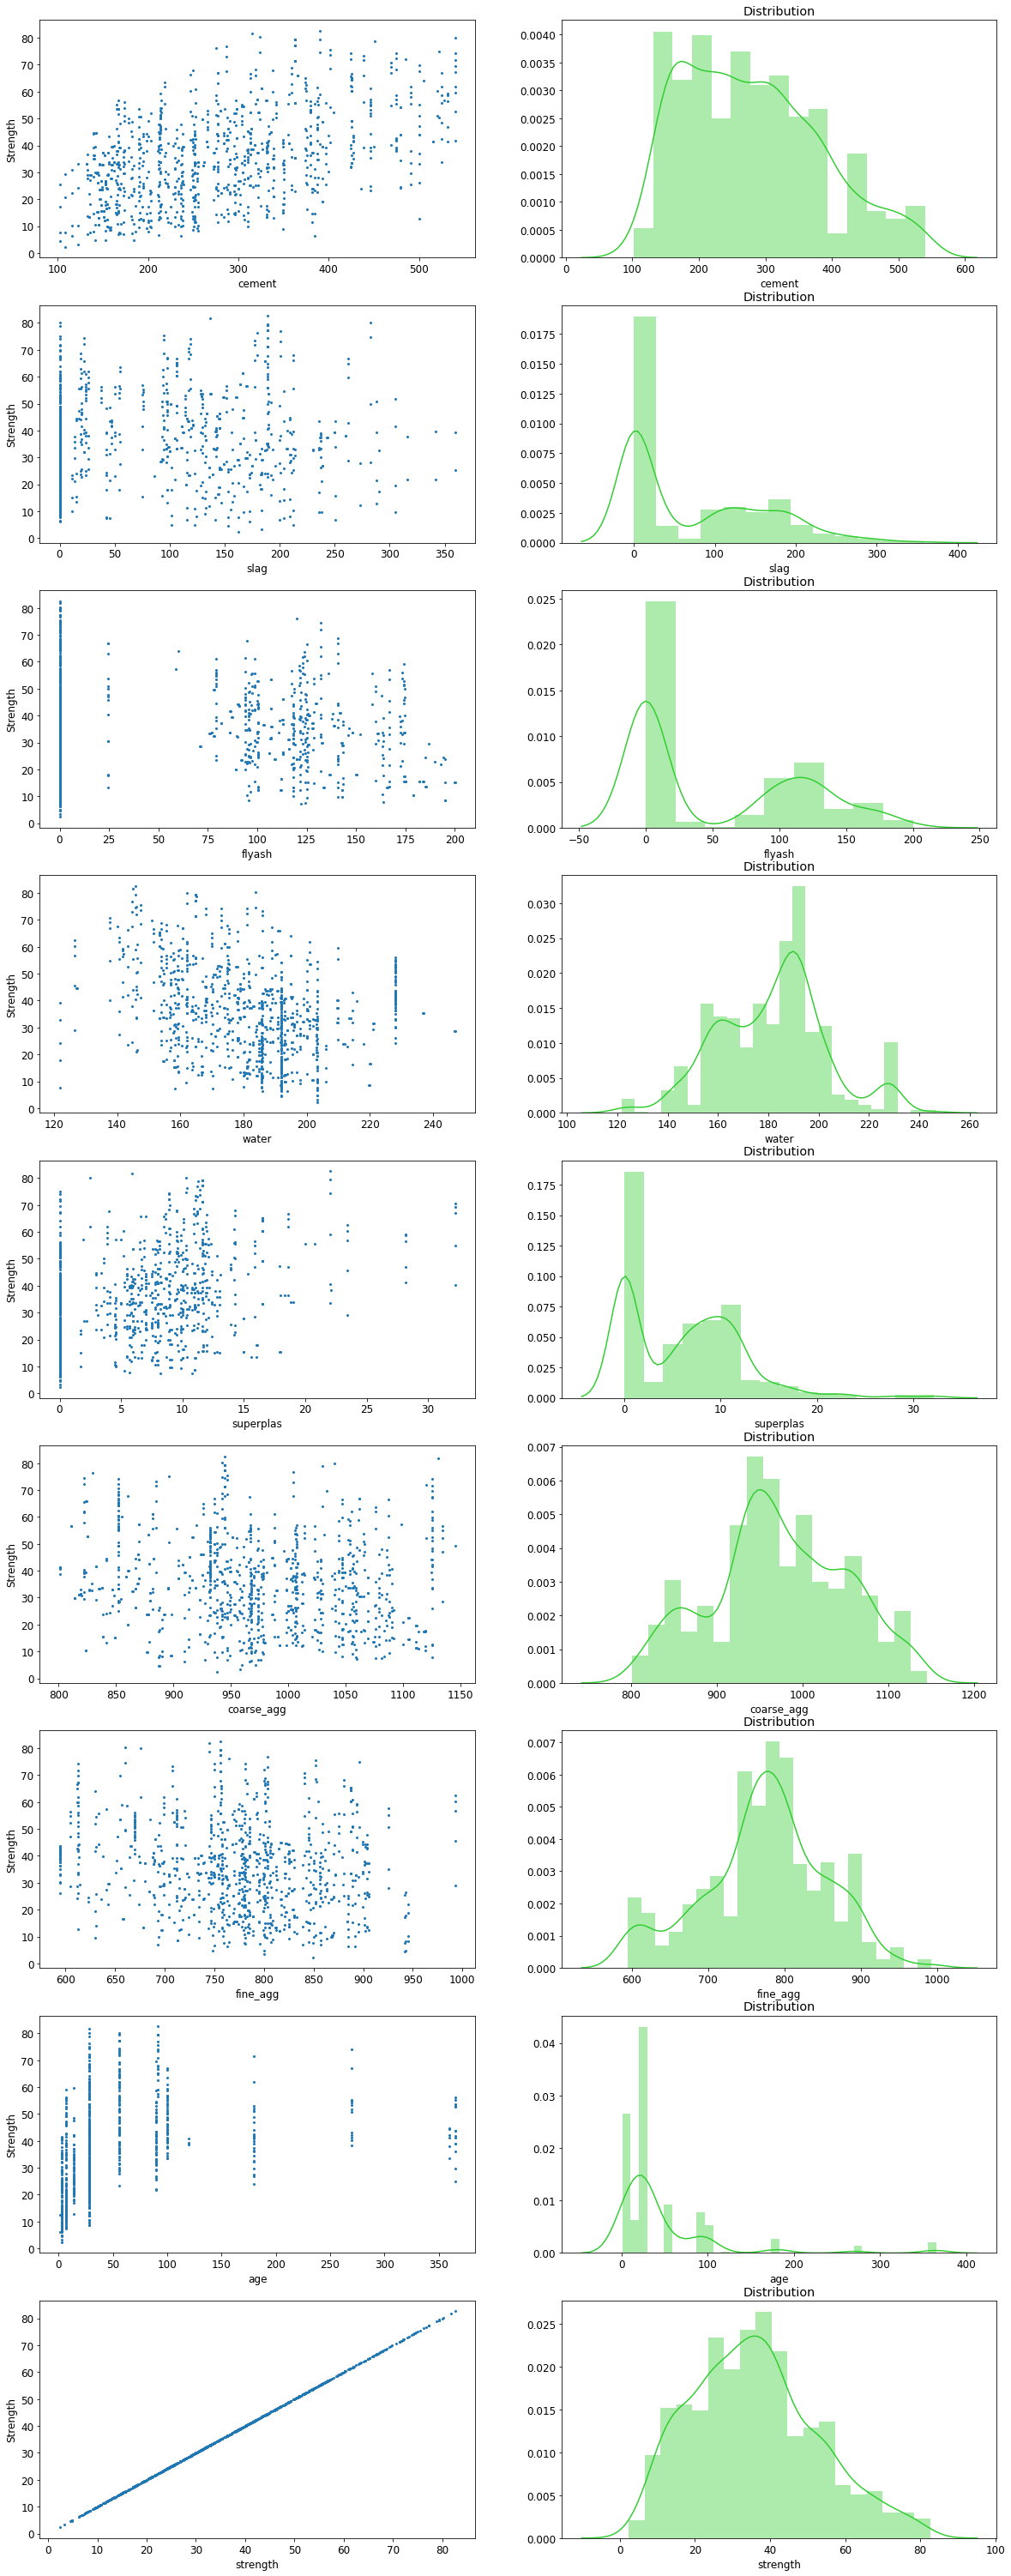

In [32]:
keys = [f for f in dataset.columns if dataset.dtypes[f] != 'object']

fig, ax = plt.subplots(len(keys),2,figsize=(20,len(keys)*6))

for n in range(len(keys)):
    feat = keys[n]
    ax[n,0].scatter(dataset[feat].values, dataset.strength.values, s=4)
    ax[n,0].set_ylabel("Strength")
    ax[n,0].set_xlabel(feat);
    sns.distplot(dataset[feat].dropna(), kde=True, ax=ax[n,1], color="limegreen")
    ax[n,1].set_title("Distribution")

In [33]:
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 6
import random as rn
rn.seed(seed)
np.random.seed(seed)

tf.random.set_seed(seed)

Split dataset for training and testing

In [34]:
train_dataset = dataset.sample(frac=0.8,random_state=69)
test_dataset = dataset.drop(train_dataset.index)

print(train_dataset.head(), train_dataset.shape)
print(test_dataset.head(), test_dataset.shape)

cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
42    237.5  237.5     0.0  228.0        0.0       932.0     594.0  365   
184   222.4    0.0    96.7  189.3        4.5       967.1     870.3    3   
131   379.5  151.2     0.0  153.9       15.9      1134.3     605.0   28   
550   393.0    0.0     0.0  192.0        0.0       940.6     785.6    7   
808   252.0    0.0     0.0  186.0        0.0      1111.0     784.0    7   

     strength  
42      39.00  
184     11.58  
131     52.20  
550     27.74  
808     11.47(824, 9)
    cement   slag  flyash  water  superplas  coarse_agg  fine_agg  age  \
9    475.0    0.0     0.0  228.0        0.0       932.0     594.0   28   
19   475.0    0.0     0.0  228.0        0.0       932.0     594.0  180   
24   380.0    0.0     0.0  228.0        0.0       932.0     670.0  365   
37   332.5  142.5     0.0  228.0        0.0       932.0     594.0   90   
39   237.5  237.5     0.0  228.0        0.0       932.0     594.0  180   

    str

In [35]:
train_stats = train_dataset.describe()
train_stats.pop('strength')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
cement,824.0,281.377306,104.495567,102.0,194.4,269.40,351.250,540.0
slag,824.0,73.903277,86.092338,0.0,0.0,22.00,142.500,359.4
flyash,824.0,53.997937,63.164905,0.0,0.0,0.00,118.300,195.0
water,824.0,181.990413,21.217147,121.8,164.9,185.70,192.000,247.0
superplas,824.0,6.206311,6.001590,0.0,0.0,6.35,10.325,32.2
coarse_agg,824.0,972.764320,78.171931,801.0,932.0,968.00,1030.000,1145.0
fine_agg,824.0,773.141262,80.462484,594.0,724.3,780.10,824.250,992.6
age,824.0,44.993932,62.216931,1.0,7.0,28.00,56.000,365.0


In [36]:
train_labels = train_dataset.pop('strength')
test_labels = test_dataset.pop('strength')

print(train_labels.head(), train_labels.shape)

42     39.00
184    11.58
131    52.20
550    27.74
808    11.47
Name: strength, dtype: float64(824,)


## Standardise Data

Data is can be normalised or standardised to improve model performance. 
- Normalisation remaps values to fit between 0 and 1.
- Standardisation remaps values to so that the mean of observed values is 0 and the standard deviation is 1. Standardisation assumes that the data fits a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. However, data can still be standardised if this condition is not met, but may yield unreliable results.

In this case, standardisation is chosen after comparing performance of the models.

cement      slag    flyash     water  superplas  coarse_agg  fine_agg  \
42  -0.419896  1.900247 -0.854872  2.168510  -1.034111   -0.521470 -2.226395   
184 -0.564400 -0.858419  0.676041  0.344513  -0.284310   -0.072460  1.207504   
131  0.939013  0.897835 -0.854872 -1.323949   1.615187    2.066415 -2.089685   
550  1.068205 -0.858419 -0.854872  0.471769  -1.034111   -0.411456  0.154839   
808 -0.281134 -0.858419 -0.854872  0.188979  -1.034111    1.768354  0.134954   

          age  
42   5.143392  
184 -0.674960  
131 -0.273140  
550 -0.610669  
808 -0.610669


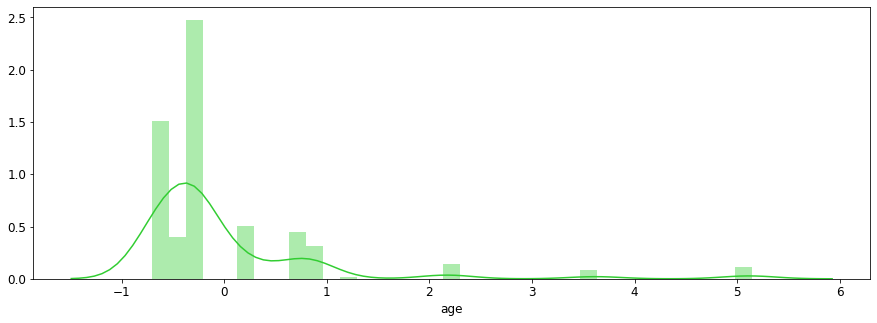

In [37]:
# Define function to normalise/standardise dataset.
# Replace the function below with this one for normalistion:
  # return (x - train_stats['min']) / (train_stats['max'] - train_stats['min'])

def standardise(x):
  return (x - train_stats['mean']) / train_stats['std'] # Standardise

# Standardise training and test dataset
normed_train_data = standardise(train_dataset)
normed_test_data = standardise(test_dataset)

# Check the dataset after standardisation:
print(normed_train_data.head())

sns.distplot(normed_train_data['age'], kde=True, color="limegreen")


# Create Model

Create sequential artificial neural network with 8 inputs, 3 hidden layers and 1 output.

- Dropout layers are set between dense layers to reduce overfitting.
- L2 Regularisers are used with λ = 0.01 to further reduce overfitting.
- The model is trained for metrics in MAE (mean absolute error) and MSE (mean squared error).
- Batch size is set to 32. (Although I have read 'batch size' = 'sample size' will give more accurate results, 32 is performing better in this model)
- Validation set is 20% of the training set.
- Early stop is called when validation loss stops improving after 20 epochs.

In [50]:
# Define training function with structure, activation, optimizer and epochs
def train_network(structure, activation, optimizer, epochs):
    model = keras.models.Sequential()

# See above for model details
    model.add(keras.layers.Dense(units = structure[1], input_dim = structure[0], activation = activation, kernel_regularizer=regularizers.l2(0.01))) 
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[2], activation = activation, kernel_regularizer=regularizers.l2(0.01)))
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[3], activation = activation, kernel_regularizer=regularizers.l2(0.01)))
    layers.Dropout(0.5)
    model.add(keras.layers.Dense(units = structure[-1], activation = None)) # activation = none is the same as linear activation

# Compile model
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])

# Print summary of network that is being trained
    print(model.summary(), '\n')
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    
    training_stats = model.fit(normed_train_data, train_labels, batch_size = 32, epochs = epochs, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

    return training_stats, model

## Training Loop
Trial and error for different number of hidden neurons to optimise for MSE and MAE.

===== Evaluating model with 128 hidden neurons...===== 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_23 (Dense)             (None, 128)               1152
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129
Total params: 34,305
Trainable params: 34,305
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae       mse   val_loss   val_mae    val_mse  epoch
173  13.854501  2.115229  9.384521  27.824814  3.346537  23.355484    173
174  11.578118  1.948918  7.106730  30.441244  3.639654  25.968

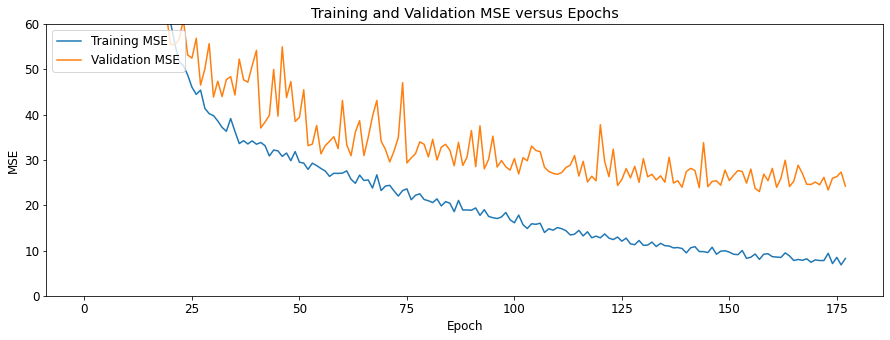

===== Evaluating model with 160 hidden neurons...===== 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_27 (Dense)             (None, 160)               1440
_________________________________________________________________
dense_28 (Dense)             (None, 160)               25760
_________________________________________________________________
dense_29 (Dense)             (None, 160)               25760
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 161
Total params: 53,121
Trainable params: 53,121
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae       mse   val_loss   val_mae    val_mse  epoch
173  14.169363  2.095729  9.141642  31.896286  3.533282  26.870525    173
174  11.395352  1.832928  6.371451  33.991398  3.773930  28.971

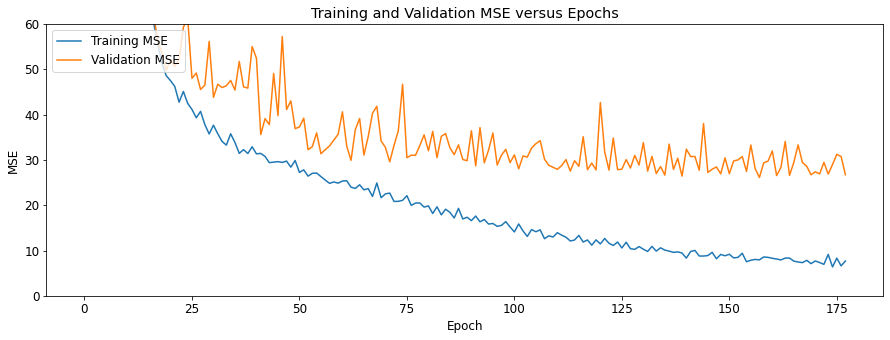

===== Evaluating model with 192 hidden neurons...===== 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_31 (Dense)             (None, 192)               1728
_________________________________________________________________
dense_32 (Dense)             (None, 192)               37056
_________________________________________________________________
dense_33 (Dense)             (None, 192)               37056
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 193
Total params: 76,033
Trainable params: 76,033
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae        mse   val_loss   val_mae    val_mse  epoch
112  17.041601  2.565814  11.579303  35.730160  3.948785  30.268818    112
113  15.866182  2.400841  10.397277  34.974606  3.972327  29.

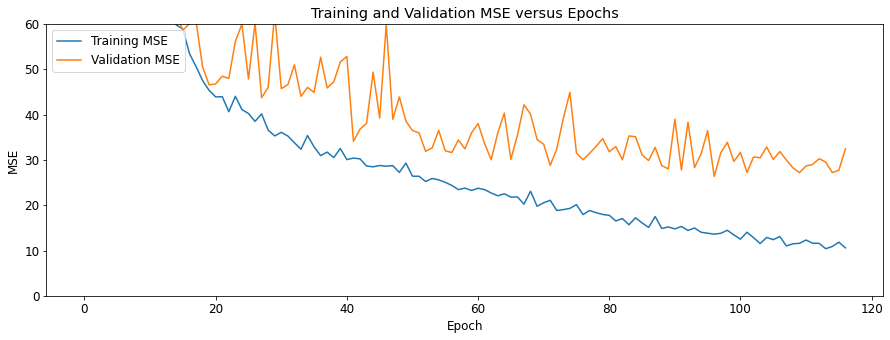

===== Evaluating model with 224 hidden neurons...===== 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_35 (Dense)             (None, 224)               2016
_________________________________________________________________
dense_36 (Dense)             (None, 224)               50400
_________________________________________________________________
dense_37 (Dense)             (None, 224)               50400
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 225
Total params: 103,041
Trainable params: 103,041
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae        mse   val_loss   val_mae    val_mse  epoch
112  17.126770  2.508610  11.229271  33.909653  3.695019  28.009718    112
113  16.977797  2.450944  11.073454  33.692078  3.777219  2

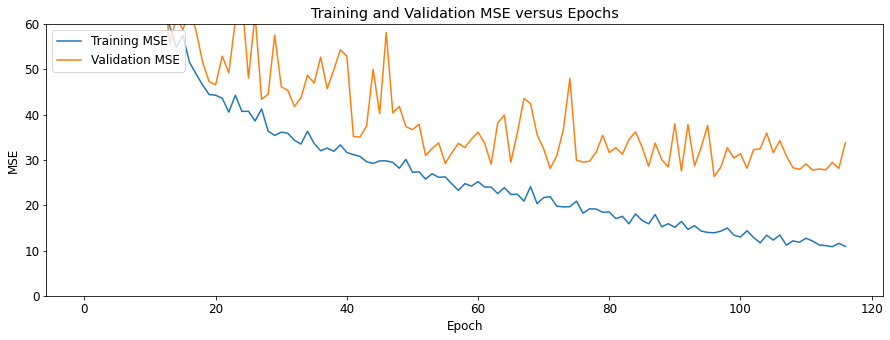

===== Evaluating model with 256 hidden neurons...===== 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_39 (Dense)             (None, 256)               2304
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257
Total params: 134,145
Trainable params: 134,145
Non-trainable params: 0
_________________________________________________________________
None

          loss       mae       mse   val_loss   val_mae    val_mse  epoch
155  13.713805  1.985784  7.454294  40.066280  4.215212  33.810604    155
156  13.950778  2.037771  7.695441  32.586452  3.468468  26.

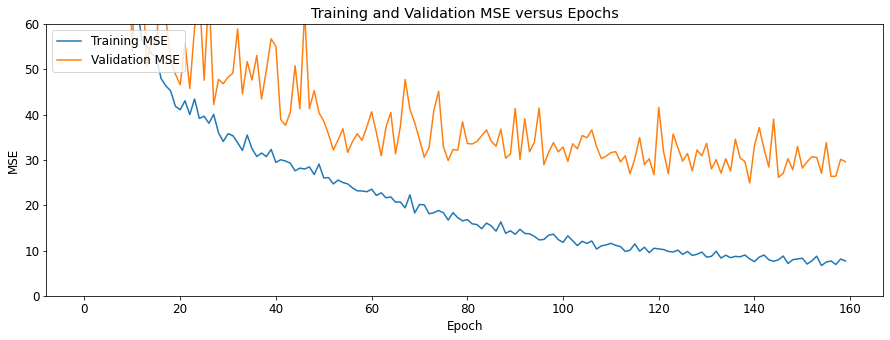

In [51]:
for hidden1 in range (128, 257, 32):
    print('===== Evaluating model with %i hidden neurons... ' %hidden1, '===== \n')
    training_stats, model = train_network(structure = [8, hidden1, hidden1, hidden1, 1], activation = 'tanh', optimizer = 'RMSprop', epochs = 512)
    hist = pd.DataFrame(training_stats.history)
    hist['epoch'] = training_stats.epoch
    print(hist.tail(), '\n')

    plt.plot(training_stats.history['mse'])
    plt.plot(training_stats.history['val_mse'])
    plt.title('Training and Validation MSE versus Epochs')
    plt.ylim([0,60])
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Training MSE', 'Validation MSE'], loc='upper left')
    plt.show()

In [40]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPa".format(mae))

7/7 - 0s - loss: 38.8892 - mae: 4.1698 - mse: 32.4217
Testing set Mean Abs Error:  4.17 MPa


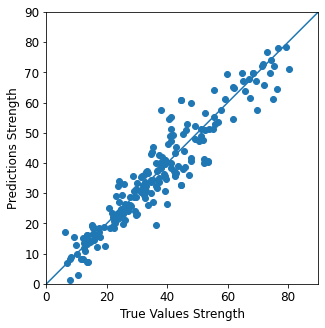

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Strength')
plt.ylabel('Predictions Strength')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

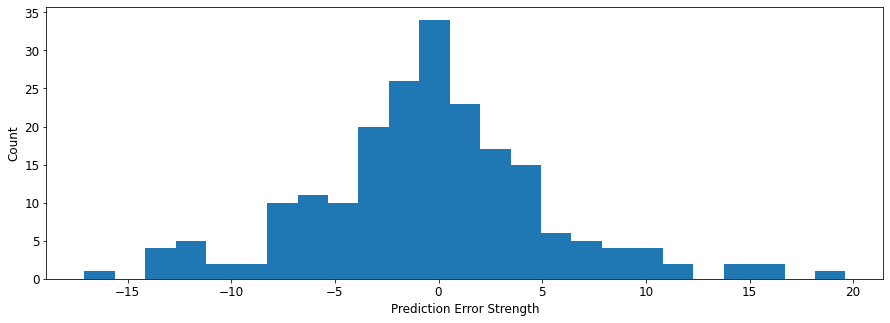

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error Strength")
_ = plt.ylabel("Count")

# Automating Hyperparameter tuning with Keras Tuner

Hyperparameter tuning can be automated with Keras Tuner which provides tools to trial and error more efficiently. A hypermodel is defined by subclassing the the `HyperModel` class of the Keras Tuner API (more details here)[https://keras-team.github.io/keras-tuner/#you-can-use-a-hypermodel-subclass-instead-of-a-model-building-function]. 

Search spaces for the number of hidden neurons and activation function are defined for Keras Tuner to loop over. Since this is a regression model, `relu`, `tanh` and `sigmoid` are selected as possible activation functions.

Keras Tuner provides various inbuilt tuners available: `BayesianOptimization`, `Hyperband`, `RandomSearch`, and `Sklearn`


In [67]:
# Define hypermodel as subclass of the HyperModel class in Keras Tuner API
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape    
        
    def build(self, hp):
        model = keras.models.Sequential()
        # Add hidden layers, input layers and corresponding search spaces
        model.add(
            keras.layers.Dense(
                input_shape=input_shape,
                units=hp.Int('units', 128, 257, 16, default=128), 
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                kernel_regularizer=regularizers.l2(0.01),
            )
        )
        # Add dropout layers
        model.add(
            layers.Dropout(0.4)
        ) 
        model.add(
            keras.layers.Dense(
                units=hp.Int('units', 128, 257, 16, default=128),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                kernel_regularizer=regularizers.l2(0.01),
            )
        )
        model.add(
            layers.Dropout(0.4)
        ) 
        # Add output layer and compile model.
        model.add(layers.Dense(1))
        model.compile(
            optimizer='RMSprop', loss='mse', metrics=['mae','mse']
        )
        return model

## Bayesian Optimisation

Instantiate tuner and perform hypertuning with Bayesian optimisation. Bayesian optimisation uses probability to find the best model by keeping track of past evaluations.

In [70]:
# Define input dimensions
input_shape = (normed_train_data.shape[1],)
# Create instance of HyperModel class
hypermodel = RegressionHyperModel(input_shape)
# Call early stop if validation loss does not improve after 20 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Instantiate tuner
tuner_bo = BayesianOptimization(
            hypermodel,
            objective = 'mse', # Set Keras Tuner to optimise for MSE metric.
            seed = 42, # Setting a seed for reproducbility.
            max_trials = 16, # How many variations (permutations) on model?
            executions_per_trial = 2, # How many trials per variation? (same model could perform differently in separate runs)
            project_name = 'concrete', # Save tuning models for later in this directory './concrete/kerastuner/bayesianOptimisation'
            directory = 'kerastuner/bayesianOptimisation')

# Perform hypertuning
tuner_bo.search(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

# Return the best model, its hyperparameters and network summary.
best_model_bo = tuner_bo.get_best_models()[0]
print('\n ===== The best hyperparameters were:', tuner_bo.get_best_hyperparameters()[0].values, '===== \n')
print('\n ===== Summary of best model ===== \n')
tuner_bo.get_best_models()[0].summary()

# Return loss, MSE and MAE for the best model
print('\n ===== MSE MAE ===== \n')
loss, mse, mae = best_model_bo.evaluate(normed_test_data, test_labels)


INFO:tensorflow:Oracle triggered exit

 ===== The best hyperparameters were:{'units': 240, 'dense_activation': 'tanh'}===== 


 ===== Summary of best model ===== 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 240)               2160
_________________________________________________________________
dropout (Dropout)            (None, 240)               0
_________________________________________________________________
dense_1 (Dense)              (None, 240)               57840
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 241
Total params: 60,241
Trainable params: 60,241
Non-trainable params: 0
___________________________________________________________

## Random Search

Instantiate tuner and perform hypertuning with random searching. Random searching will randomly try hyperparameters in the search space and return the best one.

In [72]:
# Properties in this are the same as for Bayesian optimisation above:
tuner_rs = RandomSearch(
            hypermodel,
            objective = 'mse',
            seed = 42,
            max_trials = 16,
            executions_per_trial=2,
            project_name = 'concrete',
            directory='kerastuner/randomSearch')

# Perform hypertuning
tuner_rs.search(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

# Return the best model, its hyperparameters and network summary.
best_model_rs = tuner_rs.get_best_models()[0]
tuner_rs.get_best_hyperparameters()[0].values
tuner_rs.get_best_models()[0].summary()

# Return loss, MSE and MAE for the best model
loss, mse, mae = best_model_rs.evaluate(normed_test_data, test_labels)

INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 176)               1584
_________________________________________________________________
dropout (Dropout)            (None, 176)               0
_________________________________________________________________
dense_1 (Dense)              (None, 176)               31152
_________________________________________________________________
dropout_1 (Dropout)          (None, 176)               0
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 177
Total params: 32,913
Trainable params: 32,913
Non-trainable params: 0
_________________________________________________________________
1/7 [===>..........................] - ETA: 0s - loss: 63.2571 - mae: 6.5462 - mse: 60.2937/7 [========================

## Hyperband

Instantiate tuner and perform hypertuning with Hyperband. Hyperband is based on the algorithm by (Li et. al)[http://jmlr.org/papers/v18/16-558.html]. Roughly speaking, it is an optimised version of random search.

In [73]:
# Properties in this are the same as for Bayesian optimisation above excapt for max_epochs:
tuner_hb = Hyperband(
            hypermodel,
            objective='mse',
            max_epochs=192, # For Keras Tuner Docs: 'The maximum number of epochs to train one model. It is recommended to set this to a value slightly higher than the expected time to convergence for your largest Model'
            seed=42,
            executions_per_trial=2,
            project_name = 'concrete',
            directory='kerastuner/hyperBand')

# Perform hypertuning
tuner_hb.search(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

# Return the best model, its hyperparameters and network summary.
best_model_hb = tuner_hb.get_best_models()[0]
tuner_hb.get_best_hyperparameters()[0].values
tuner_hb.get_best_models()[0].summary()

# Return loss, MSE and MAE for the best model
loss, mse, mae = best_model_hb.evaluate(normed_test_data, test_labels)

INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense (Dense)                (None, 256)               2304
_________________________________________________________________
dropout (Dropout)            (None, 256)               0
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257
Total params: 68,353
Trainable params: 68,353
Non-trainable params: 0
_________________________________________________________________
1/7 [===>..........................] - ETA: 0s - loss: 306.7525 - mae: 14.2035 - mse: 303.377/7 [======================

# Results

Putting it all together, the optimal model for this project has:
- 3 hidden layers 
- `tanh` as the activation function.
- 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_11 (Dense)             (None, 256)               2304
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257
Total params: 134,145
Trainable params: 134,145
Non-trainable params: 0
_________________________________________________________________
None

         loss       mae        mse   val_loss   val_mae    val_mse  epoch
87  22.177208  2.968667  15.780072  40.505779  4.168047  34.107052     87
88  19.436878  2.715829  13.026970  35.227863  3.852586  28.810366     88
89  20.167316  2.766845  13.744842  36.13793

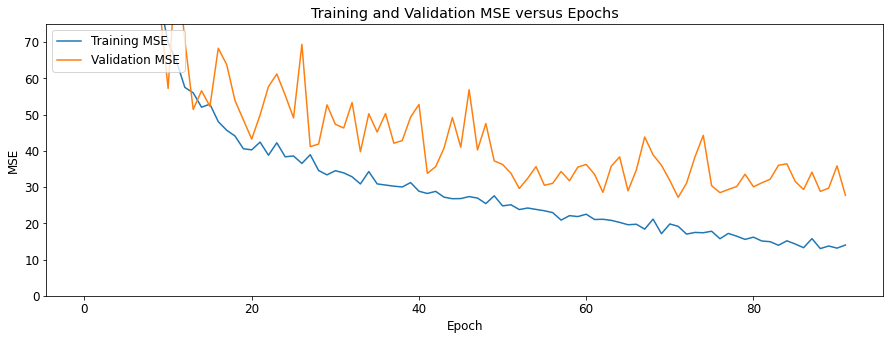

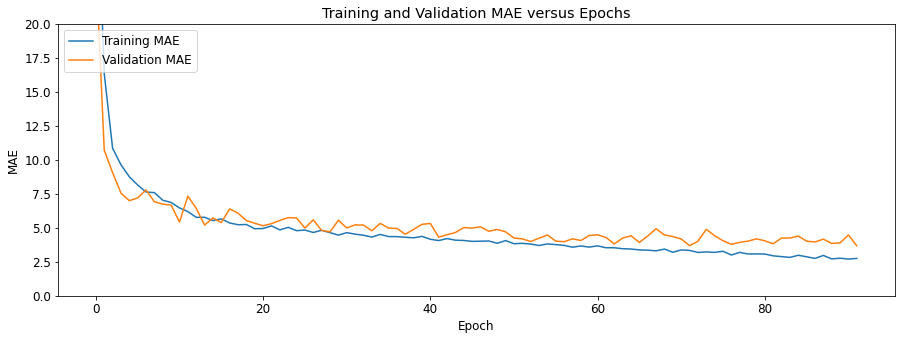

In [77]:
# Define training function with structure, activation, optimizer and epochs
model = keras.models.Sequential()

# See above for model details
model.add(keras.layers.Dense(units = 256, input_dim = 8, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01))) 
layers.Dropout(0.5)
model.add(keras.layers.Dense(units = 256, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01)))
layers.Dropout(0.5)
model.add(keras.layers.Dense(units = 256, activation = 'tanh', kernel_regularizer=regularizers.l2(0.01)))
layers.Dropout(0.5)
model.add(keras.layers.Dense(units = 1, activation = None)) # activation = none is the same as linear activation

# Compile model
model.compile(loss = 'mse', optimizer = 'RMSprop', metrics = ['mae', 'mse'])

# Print summary of network that is being trained
print(model.summary(), '\n')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

training_stats = model.fit(normed_train_data, train_labels, batch_size = 32, epochs = 512, validation_split = 0.2, verbose = 0, callbacks=[early_stop])

hist = pd.DataFrame(training_stats.history)
hist['epoch'] = training_stats.epoch
print(hist.tail(), '\n')

plt.plot(training_stats.history['mse'])
plt.plot(training_stats.history['val_mse'])
plt.title('Training and Validation MSE versus Epochs')
plt.ylim([0,75])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training MSE', 'Validation MSE'], loc='upper left')
plt.show()

plt.plot(training_stats.history['mae'])
plt.plot(training_stats.history['val_mae'])
plt.title('Training and Validation MAE versus Epochs')
plt.ylim([0,20])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training MAE', 'Validation MAE'], loc='upper left')
plt.show()

In [78]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPa".format(mae))

7/7 - 0s - loss: 34.3210 - mae: 3.8777 - mse: 27.8718
Testing set Mean Abs Error:  3.88 MPa


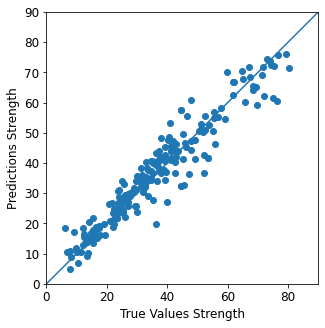

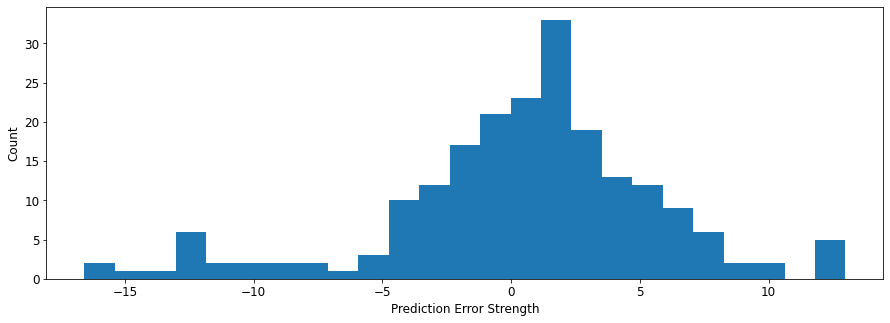

In [80]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Strength')
plt.ylabel('Predictions Strength')
lims = [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error Strength")
_ = plt.ylabel("Count")
plt.show()